In [ ]:
# Testing mlflow running on ec2 instance.

# import mlflow

# mlflow.set_tracking_uri("http://13.201.83.107:5000/")

# with mlflow.start_run():
#     mlflow.log_param("param1", 15)
#     mlflow.log_metric("metric1", 0.89)

In [2]:
import numpy as np
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
data.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [4]:
data.dropna(inplace = True)
data.drop_duplicates(inplace = True)

In [5]:
data = data[~(data['clean_comment'].str.strip() == '')]

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [7]:
# Define the preprocessing function.

def preprocess_comment(comment):
    # Convert to lowercase.
    comment = comment.lower()

    # Remove trailing and leading whitespaces.
    comment = comment.strip()

    # Remove newline characters.
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation.
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis.
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words.
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [8]:
data['clean_comment'] = data['clean_comment'].apply(preprocess_comment)

In [9]:
data.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [10]:
# Step 1: Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features = 10000) 

X = vectorizer.fit_transform(data['clean_comment']).toarray()
y = data['category']  

In [11]:
# Step 2: Set up the MLflow tracking server.
mlflow.set_tracking_uri("http://43.204.102.160:5000/")
mlflow.set_experiment("RF Baseline")

<Experiment: artifact_location='s3://dj-mlflow-experiment/682028795779064385', creation_time=1759531947426, experiment_id='682028795779064385', last_update_time=1759531947426, lifecycle_stage='active', name='RF Baseline', tags={'mlflow.experimentKind': 'custom_model_development'}>

2025/10/04 04:43:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/04 04:43:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_Baseline_TrainTestSplit at: http://43.204.102.160:5000/#/experiments/682028795779064385/runs/e9e96da997e549ccbeaba7e1cfab8571.
2025/10/04 04:43:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://43.204.102.160:5000/#/experiments/682028795779064385.


Accuracy: 0.6483217828509308


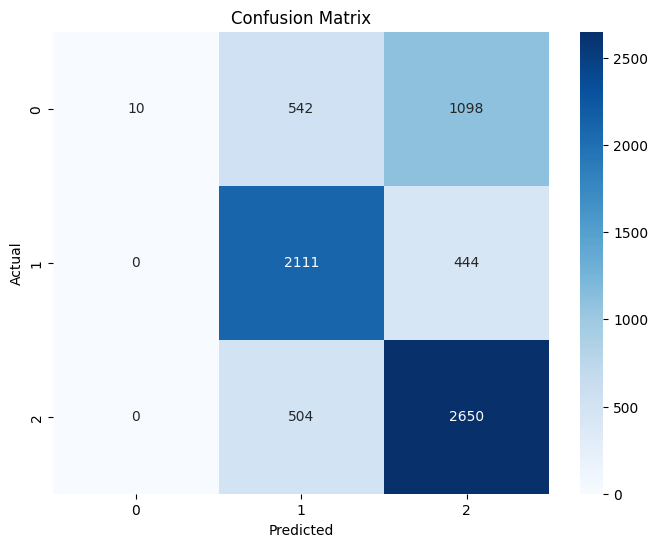

In [12]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Step 2: Define and train a Random Forest baseline model using a simple train-test split.
with mlflow.start_run() as run:
    
    # Log a description for the run.
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description.
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer.
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters.
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model.
    model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, random_state = 42)
    model.fit(X_train, y_train)

    # Make predictions on the test set.
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy.
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict = True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict): 
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot.
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (8, 6))
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot.
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the Random Forest model.
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Optionally log the dataset itself (if it's small enough).
    data.to_csv("dataset.csv", index = False)
    mlflow.log_artifact("dataset.csv")

# Display final accuracy.
print(f"Accuracy: {accuracy}")

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.01      0.01      1650
           0       0.67      0.83      0.74      2555
           1       0.63      0.84      0.72      3154

    accuracy                           0.65      7359
   macro avg       0.77      0.56      0.49      7359
weighted avg       0.73      0.65      0.57      7359



In [14]:
data.to_csv('reddit_preprocessed.csv', index = False)